In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fancyimpute import mice
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

Using TensorFlow backend.


In [2]:
pd.set_option('display.float_format',lambda x:'%.4f'%x)

df_train_x = pd.read_csv('../data/train_values_6tLXv3T.csv', encoding='utf8')
df_test_x = pd.read_csv('../data/test_values_K7FqC54.csv', encoding='utf8')
df_train_y = pd.read_csv('../data/train_labels.csv', encoding='utf8')
df_test_y = pd.read_csv('../data/submission_format_klDJt5C.csv', encoding='utf8')

In [3]:
data_describe1 = pd.read_csv('train_x_describe.csv', index_col=0)
data_describe2 = pd.read_csv('test_x_describe.csv', index_col=0)

In [4]:
# combin df_train_x and df_train_y as df_train_all
df_train_all = pd.concat([df_train_x,df_train_y['prevalence_of_undernourishment']],axis=1)
df_train_all.shape

(1401, 47)

---  
# Cleaning Data: Trainning Data
--- 
### column 'droughts_floods_extreme_temps' fill with 0

In [5]:
df_train_all['droughts_floods_extreme_temps'] = df_train_all.droughts_floods_extreme_temps.fillna(0)

---   
### df_train_x drop columns if the missing value is over 40%

In [6]:
# df_train_all: 
data_describe1[data_describe1['null_rate']>0.4]

,duplicate,is_null,null_number,null_rate
droughts_floods_extreme_temps,76,True,1326,0.9465
inequality_index,430,True,972,0.6938
adult_literacy_rate,286,True,1116,0.7966
school_enrollment_rate_female,796,True,606,0.4325
rail_lines_density,450,True,944,0.6738


In [7]:
# df_test_x: 
data_describe2[data_describe2['null_rate']>0.4]

,duplicate,is_null,null_number,null_rate
droughts_floods_extreme_temps,35,True,582,0.9448
inequality_index,140,True,477,0.7744
tax_revenue_share_gdp,367,True,250,0.4058
adult_literacy_rate,108,True,509,0.8263
rail_lines_density,197,True,420,0.6818


In [8]:
# use training data to deside which columns should be drroped
drop_col = list(data_describe1[data_describe1['null_rate']>0.4].index)

In [9]:
df_train_all.drop(drop_col, axis=1, inplace=True)
df_train_all.shape

(1401, 42)

---   
### column 'year' do one-hot-encoding

In [10]:
df_train_all = pd.get_dummies(data=df_train_all, columns=['year'], prefix='year')
df_train_all.shape

(1401, 57)

---   
### drop column 'country_code' 

In [11]:
df_train_all.drop('country_code', axis = 1, inplace=True);
df_train_all.shape

(1401, 56)

---   
### take out the columns that have less than 0.2 correlation with prevalence_of_undernourishment

In [12]:
drop_list=[]
for i in df_train_all.columns[2:]:
    if abs(df_train_all['prevalence_of_undernourishment'].corr(df_train_all[i])) <0.2:
        drop_list.append(i)

df_train_all.drop(drop_list, axis = 1, inplace=True);
df_train_all.shape

(1401, 21)

--- 
### use KNN method to filled the null values 

In [13]:
# def fill_ii(df):
#     df_new=df.iloc[:,2:]
#     df_filled_ii = pd.DataFrame(IterativeImputer().fit_transform(df_new.as_matrix()))
#     df_filled_ii.columns = df_new.columns
#     df_filled_ii.index = df_new.index

#     return df_filled_ii


def fill_knn(df):
    df_filled_knn =pd.DataFrame(KNN(k=5).fit_transform(df.as_matrix()))
    df_filled_knn.columns = df.columns
    df_filled_knn.index = df.index

    return df_filled_knn

In [14]:
# use KNN method to filled the null values

df_filled_knn = fill_knn(df_train_all)
df_filled_knn.shape

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


Imputing row 1/1401 with 1 missing, elapsed time: 0.429
Imputing row 101/1401 with 0 missing, elapsed time: 0.432
Imputing row 201/1401 with 3 missing, elapsed time: 0.435
Imputing row 301/1401 with 0 missing, elapsed time: 0.438
Imputing row 401/1401 with 0 missing, elapsed time: 0.441
Imputing row 501/1401 with 0 missing, elapsed time: 0.444
Imputing row 601/1401 with 1 missing, elapsed time: 0.447
Imputing row 701/1401 with 1 missing, elapsed time: 0.450
Imputing row 801/1401 with 0 missing, elapsed time: 0.453
Imputing row 901/1401 with 0 missing, elapsed time: 0.455
Imputing row 1001/1401 with 0 missing, elapsed time: 0.457
Imputing row 1101/1401 with 1 missing, elapsed time: 0.460
Imputing row 1201/1401 with 1 missing, elapsed time: 0.464
Imputing row 1301/1401 with 7 missing, elapsed time: 0.466
Imputing row 1401/1401 with 0 missing, elapsed time: 0.469


(1401, 21)

In [15]:
# check it has null number or not
df_filled_knn.isnull().any().any()

False

---  
### to see the correlation between left columns

In [16]:
corr_table = df_filled_knn.corr()
corr_table

,row_id,agricultural_land_area,cereal_yield,fertility_rate,life_expectancy,population_growth,avg_value_of_food_production,gross_domestic_product_per_capita_ppp,net_oda_received_percent_gni,per_capita_food_production_variability,...,avg_supply_of_protein_of_animal_origin,caloric_energy_from_cereals_roots_tubers,access_to_improved_sanitation,access_to_improved_water_sources,anemia_prevalence,obesity_prevalence,open_defecation,access_to_electricity,political_stability,prevalence_of_undernourishment
row_id,1.0000,-0.0115,0.0086,-0.0325,0.0119,-0.0066,-0.0242,0.0156,-0.0281,-0.0121,...,0.0037,-0.0030,0.0361,0.0250,-0.0128,0.0088,-0.0364,0.0297,-0.0149,-0.0513
agricultural_land_area,-0.0115,1.0000,-0.0640,0.1275,-0.1434,0.0870,0.0444,-0.0479,-0.0670,-0.0177,...,-0.0519,0.0276,-0.1367,-0.1473,-0.0279,0.0600,0.1319,-0.0886,0.0820,0.0070
cereal_yield,0.0086,-0.0640,1.0000,-0.2928,0.2976,0.0962,0.0747,0.2450,-0.1391,0.1333,...,0.2369,-0.1631,0.3003,0.2898,-0.1860,0.2377,-0.2089,0.2772,0.1675,-0.2376
fertility_rate,-0.0325,0.1275,-0.2928,1.0000,-0.8003,0.5720,-0.2764,-0.3887,0.4148,-0.1840,...,-0.6378,0.5855,-0.7828,-0.7586,0.5953,-0.5005,0.5689,-0.8132,-0.3614,0.5003
life_expectancy,0.0119,-0.1434,0.2976,-0.8003,1.0000,-0.3475,0.2206,0.4515,-0.3159,0.1479,...,0.6607,-0.6218,0.8212,0.7418,-0.5840,0.5342,-0.5717,0.8279,0.3616,-0.4804
population_growth,-0.0066,0.0870,0.0962,0.5720,-0.3475,1.0000,-0.2892,0.0468,0.2423,-0.1151,...,-0.3286,0.3352,-0.3924,-0.3958,0.3726,-0.2655,0.2912,-0.4038,-0.1752,0.2560
avg_value_of_food_production,-0.0242,0.0444,0.0747,-0.2764,0.2206,-0.2892,1.0000,-0.1615,-0.1990,0.6619,...,0.2471,-0.2568,0.2729,0.2699,-0.3909,0.2910,-0.2678,0.3177,0.0660,-0.3727
gross_domestic_product_per_capita_ppp,0.0156,-0.0479,0.2450,-0.3887,0.4515,0.0468,-0.1615,1.0000,-0.1754,-0.0131,...,0.5710,-0.4526,0.4651,0.4025,-0.2204,0.3168,-0.3388,0.3937,0.3950,-0.3034
net_oda_received_percent_gni,-0.0281,-0.0670,-0.1391,0.4148,-0.3159,0.2423,-0.1990,-0.1754,1.0000,-0.0816,...,-0.3088,0.3120,-0.4103,-0.3684,0.1970,-0.2764,0.3739,-0.5005,-0.1306,0.3916
per_capita_food_production_variability,-0.0121,-0.0177,0.1333,-0.1840,0.1479,-0.1151,0.6619,-0.0131,-0.0816,1.0000,...,0.2254,-0.1826,0.2310,0.1730,-0.2793,0.2441,-0.2184,0.1942,0.1852,-0.2449


Text(0.5, 1.0, 'Correlation between features')

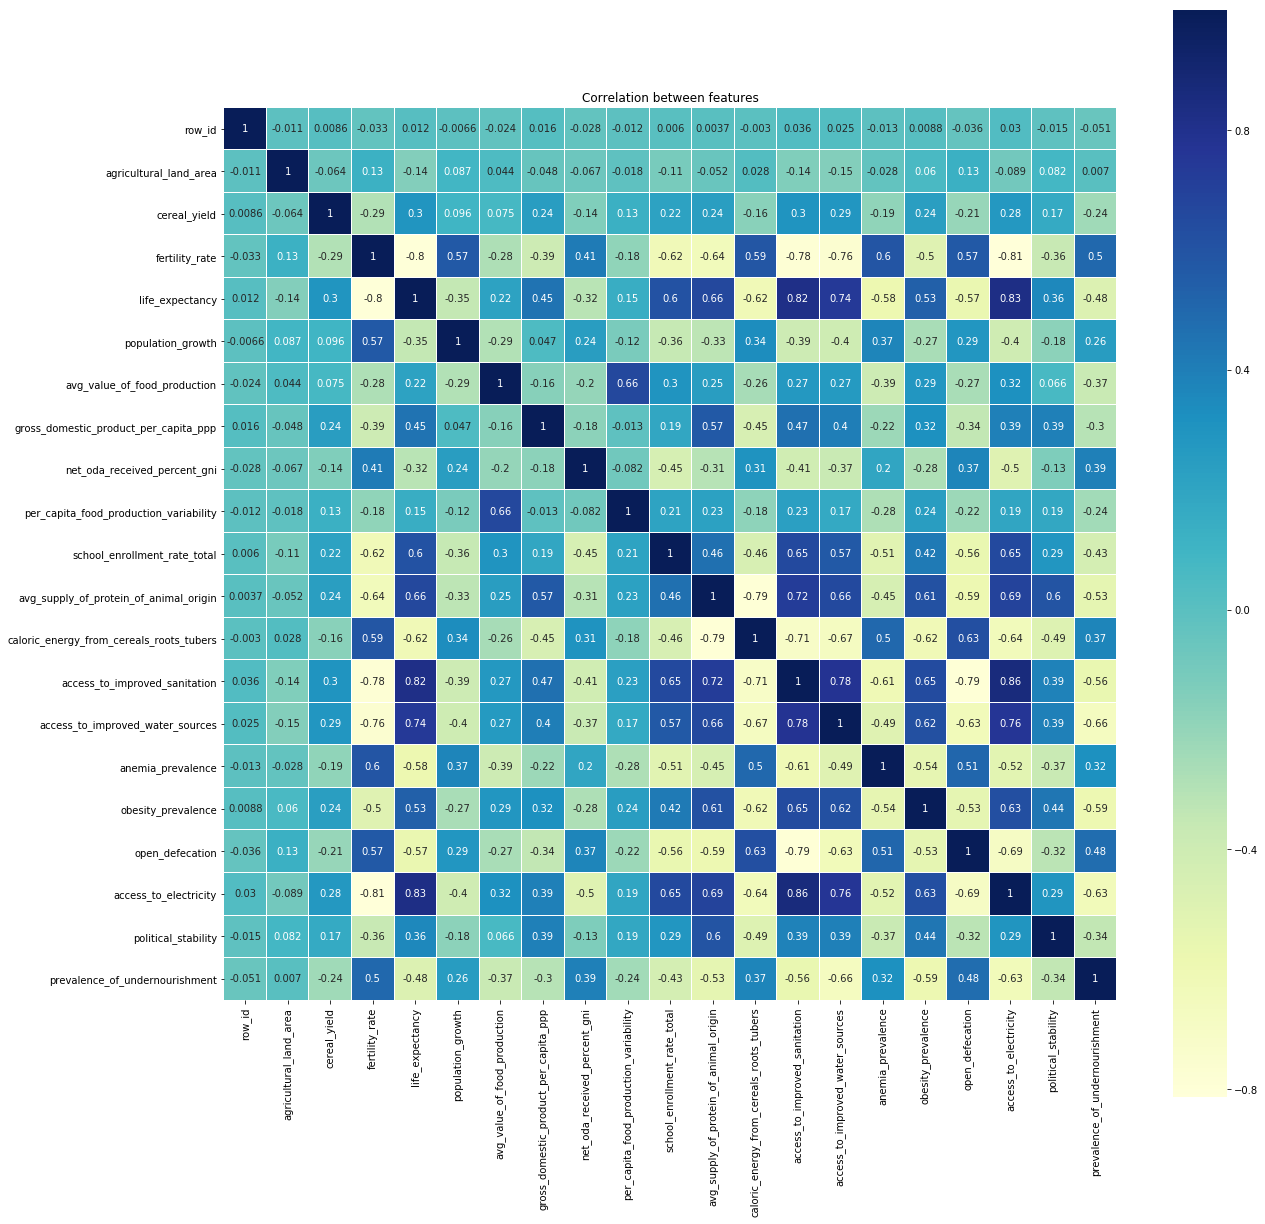

In [17]:
# Correlation between features

fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

g=sns.heatmap(corr_table, vmax=1, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features')

---
### drop some columns to prevent the multicollinearity effect (corr > 0.7)

In [18]:
# choose the columns which have high correlation between,
# then pick the low correlations between target.

left_col = list(corr_table.index)
drop_list = []

for row in left_col:
    for col in  left_col:
        if corr_table[row][col] > 0.7:
            drop_list.append([row, col])
            
drop_col = []
for pair_list in drop_list:
    if pair_list[0] == pair_list[1]:     # skip diagonal, because it always be 1
        pass
    else: 
        corr_A = corr_table['prevalence_of_undernourishment'][pair_list[0]]
        corr_B = corr_table['prevalence_of_undernourishment'][pair_list[1]]
        if corr_A > corr_B: drop_col.append(pair_list[0])
        else: drop_col.append(pair_list[1])
        
set(drop_col)

{'access_to_electricity',
 'access_to_improved_sanitation',
 'avg_supply_of_protein_of_animal_origin',
 'life_expectancy'}

In [19]:
# drop the columns above

df_filled_knn = df_filled_knn.drop(columns=set(drop_col))
df_filled_knn.shape

(1401, 17)

In [20]:
col_remain = list(df_filled_knn.columns)
col_remain

['row_id',
 'agricultural_land_area',
 'cereal_yield',
 'fertility_rate',
 'population_growth',
 'avg_value_of_food_production',
 'gross_domestic_product_per_capita_ppp',
 'net_oda_received_percent_gni',
 'per_capita_food_production_variability',
 'school_enrollment_rate_total',
 'caloric_energy_from_cereals_roots_tubers',
 'access_to_improved_water_sources',
 'anemia_prevalence',
 'obesity_prevalence',
 'open_defecation',
 'political_stability',
 'prevalence_of_undernourishment']

### Delete Outlier

In [21]:
def filter_extreme_3sigma(df, tar_list, n=3):
    df_new = pd.DataFrame()
    for col in tar_list:
        col_mean = df[col].mean()
        col_std = df[col].std()
        max_range = col_mean + n*col_std
        min_range = col_mean - n*col_std
        df_new[col] = df[col].clip(min_range, max_range)
    return df_new

In [22]:
df_filled_knn = filter_extreme_3sigma(df_filled_knn, list(df_filled_knn.columns), n=3)
print(df_filled_knn.shape)
# df_filled_knn.columns

(1401, 17)


In [23]:
# export the data after process to csv as 'train_new.csv'
df_filled_knn.to_csv('../data/train_new.csv', encoding='utf8', index=False)

---  
# Cleaning Data: Test Data
--- 

In [24]:
# drop the columns that train droped

col_remain.remove('prevalence_of_undernourishment')
df_test_x = df_test_x[col_remain]
df_test_x.shape

(616, 16)

In [25]:
# use KNN method to filled the null values

df_test_filled_knn = fill_knn(df_test_x)
df_test_filled_knn.shape

Imputing row 1/616 with 1 missing, elapsed time: 0.117
Imputing row 101/616 with 0 missing, elapsed time: 0.119
Imputing row 201/616 with 0 missing, elapsed time: 0.121
Imputing row 301/616 with 1 missing, elapsed time: 0.123
Imputing row 401/616 with 5 missing, elapsed time: 0.124
Imputing row 501/616 with 0 missing, elapsed time: 0.126
Imputing row 601/616 with 4 missing, elapsed time: 0.127


c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


(616, 16)

In [26]:
# check it has null number or not
df_test_filled_knn.isnull().any().any()

False

In [27]:
# export the data after process to csv as 'train_new.csv'
df_test_filled_knn.to_csv('../data/test_x_new.csv', encoding='utf8', index=False)

--- 
# Summary